In [2]:
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 5.5 MB/s eta 0:00:0000:01


In [3]:
import numpy as np
import pandas as pd
import time

import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

import pickle5 as pickle
from scipy import stats

import matplotlib.ticker as tick

import sys
sys.path.append('..')
#from nsgp_vi import nsgpVI

# We'll use double precision throughout for better numerics.
dtype = np.float64

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

plt.style.use('ggplot') 
plt.style.use('seaborn-paper')
plt.style.use('seaborn-whitegrid')


In [4]:
# Extracted from https://github.com/OpenNMT/OpenNMT-tf/blob/master/opennmt/optimizers/utils.py

import tensorflow as tf

class GradientAccumulator(object):
    """Gradient accumulation utility.
    When used with a distribution strategy, the accumulator should be called in a
    replica context. Gradients will be accumulated locally on each replica and
    without synchronization. Users should then call ``.gradients``, scale the
    gradients if required, and pass the result to ``apply_gradients``.
    """

    # We use the ON_READ synchronization policy so that no synchronization is
    # performed on assignment. To get the value, we call .value() which returns the
    # value on the current replica without synchronization.

    def __init__(self):
        """Initializes the accumulator."""
        self._gradients = []
        self._accum_steps = None

    @property
    def step(self):
        """Number of accumulated steps."""
        if self._accum_steps is None:
            self._accum_steps = tf.Variable(
                tf.constant(0, dtype=tf.int64),
                trainable=False,
                synchronization=tf.VariableSynchronization.ON_READ,
                aggregation=tf.VariableAggregation.ONLY_FIRST_REPLICA,
            )
        return self._accum_steps.value()

    @property
    def gradients(self):
        """The accumulated gradients on the current replica."""
        if not self._gradients:
            raise ValueError(
                "The accumulator should be called first to initialize the gradients"
            )
        #return list(gradient.value()/tf.cast(self._accum_steps, gradient.dtype) for gradient in self._gradients)
        grads = list(gradient.value()/tf.cast(self._accum_steps, gradient.dtype) for gradient in self._gradients)
        clipped_grads, gn = tf.clip_by_global_norm(grads,clip_norm=1.0)
        return clipped_grads
        
    
    

    def __call__(self, gradients):
        """Accumulates :obj:`gradients` on the current replica."""
        if not self._gradients:
            _ = self.step  # Create the step variable.
            self._gradients.extend(
                [
                    tf.Variable(
                        tf.zeros_like(gradient),
                        trainable=False,
                        synchronization=tf.VariableSynchronization.ON_READ,
                    )
                    for gradient in gradients
                ]
            )
        if len(gradients) != len(self._gradients):
            raise ValueError(
                "Expected %s gradients, but got %d"
                % (len(self._gradients), len(gradients))
            )

        for accum_gradient, gradient in zip(self._gradients, gradients):
            accum_gradient.assign_add(gradient, read_value=False)
        self._accum_steps.assign_add(1)

    def reset(self):
        """Resets the accumulated gradients on the current replica."""
        if not self._gradients:
            return
        self._accum_steps.assign(0)
        for gradient in self._gradients:
            gradient.assign(
                tf.zeros(gradient.shape, dtype=gradient.dtype), read_value=False
            )

In [5]:
# -*- coding: utf-8 -*-
"""nsgp_vi_3ns_params.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/11Ioi3gLbnBLEEs7JS2wX4a65E30SKNcY
"""

# %% [code]
"""
Copyright 2021 Colin Torney
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tqdm import tqdm

from tensorflow_probability.python.distributions import kullback_leibler

#from utils.gradient_accumulator import GradientAccumulator

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

dtype = np.float64
NUM_LATENT = 3

class nsgp_vi_3ns_params_2D(tf.Module):
                                        
    def __init__(self,kernel_len,kernel_amp,kernel_mean,n_inducing_points,inducing_index_points,dataset,num_training_points, init_observation_noise_variance=1e1,num_sequential_samples=10,num_parallel_samples=10,jitter=1e-6):
               
        self.jitter=jitter
        
        # define the means for all parameters including the mean
        self.mean_len = tf.Variable([0.0], dtype=tf.float64, name='len_mean', trainable=True)
        self.mean_amp = tf.Variable([0.0], dtype=tf.float64, name='var_mean', trainable=True)
        self.mean_mean = tf.Variable([0.0], dtype=tf.float64, name='mean_mean', trainable=True)

        # inducing points for all parameters including the mean, kept fixed
        self.amp_inducing_index_points = tf.Variable(inducing_index_points,dtype=dtype,name='amp_ind_points',trainable=False) #z's for amplitude
        self.len_inducing_index_points = tf.Variable(inducing_index_points,dtype=dtype,name='len_ind_points',trainable=False) #z's for len
        self.mean_inducing_index_points = tf.Variable(inducing_index_points,dtype=dtype,name='mean_ind_points',trainable=False) #z's for mean

        # prior distributions for all parameters including the mean
        self.kernel_len = kernel_len
        self.kernel_amp = kernel_amp
        self.kernel_mean = kernel_mean

        
        #parameters for variational distribution for len,phi(l_z) and var,phi(sigma_z)
        self.variational_inducing_observations_loc = tf.Variable(np.zeros((NUM_LATENT*n_inducing_points),dtype=dtype),name='ind_loc_post')
        self.variational_inducing_observations_scale = tfp.util.TransformedVariable(np.eye(NUM_LATENT*n_inducing_points, dtype=dtype),tfp.bijectors.FillScaleTriL(diag_shift=np.float64(1e-05)),dtype=tf.float64, name='ind_scale_post', trainable=True)

        
        #approximation to the posterior: phi(l_z)
        self.variational_inducing_observations_posterior = tfd.MultivariateNormalLinearOperator(
                                                                      loc=self.variational_inducing_observations_loc,
                                                                      scale=tf.linalg.LinearOperatorLowerTriangular(self.variational_inducing_observations_scale))

        #p(l_z)
        self.inducing_prior = tfd.MultivariateNormalDiag(loc=tf.zeros((NUM_LATENT*n_inducing_points),dtype=tf.float64),name='ind_prior')
        
        self.vgp_observation_noise_variance = tf.Variable(np.log(np.exp(init_observation_noise_variance)-1),dtype=dtype,name='nv', trainable=True)

        self.num_sequential_samples=num_sequential_samples
        self.num_parallel_samples=num_parallel_samples
        
        self.dataset = dataset
        self.num_training_points=num_training_points
        

    def optimize(self, BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=100):

        strategy = tf.distribute.MirroredStrategy()
        dist_dataset = strategy.experimental_distribute_dataset(self.dataset)

        initial_learning_rate = 1e-2# instead of 1e-1, 1e-2 was for the best results
        steps_per_epoch = self.num_training_points//(BATCH_SIZE*SEG_LENGTH)
        learning_rate = tf.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=steps_per_epoch,decay_rate=0.99,staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        accumulator = GradientAccumulator()

        def train_step(inputs):
            x_train_batch, y_train_batch = inputs
            kl_weight = tf.reduce_sum(tf.ones_like(x_train_batch))/self.num_training_points
            with tf.GradientTape(watch_accessed_variables=True) as tape:
                loss = self.variational_loss(observations=y_train_batch,observation_index_points=x_train_batch,kl_weight=kl_weight) 
            grads = tape.gradient(loss, self.trainable_variables)
            return loss, grads

        @tf.function
        def distributed_train_step(dataset_inputs):
            per_replica_losses, per_replica_grads = strategy.run(train_step, args=(dataset_inputs,))
            return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None), strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_grads, axis=None)
            #return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None), [strategy.reduce(tf.distribute.ReduceOp.SUM, prg, axis=None) for prg in per_replica_grads]

        pbar = tqdm(range(NUM_EPOCHS))
        loss_history = np.zeros((NUM_EPOCHS))

        for i in pbar:
            batch_count=0    
            epoch_loss = 0.0
            for batch in self.dataset:
                batch_loss = 0.0
                for s in range(self.num_sequential_samples):
                    loss, grads = distributed_train_step(batch)
                    # accumulate the loss and gradient
                    accumulator(grads)
                    batch_loss += loss.numpy()
                grads = accumulator.gradients
                optimizer.apply_gradients(zip(grads, self.trainable_variables))
                accumulator.reset()
                batch_loss/=self.num_sequential_samples
                epoch_loss+=batch_loss
                batch_count+=1
                pbar.set_description("Loss %f, kllen %f, klamp %f, klmean %f, kalen %f, kaamp %f, kamean %f, kmlen %f, kmamp %f, kmmean %f " % (epoch_loss/batch_count, self.kernel_len.length_scale.numpy(), self.kernel_len.amplitude.numpy(), self.mean_len.numpy(),self.kernel_amp.length_scale.numpy(), self.kernel_amp.amplitude.numpy(), self.mean_amp.numpy(),self.kernel_mean.length_scale.numpy(), self.kernel_mean.amplitude.numpy(), self.mean_mean.numpy()))
            loss_history[i] = epoch_loss/batch_count

        return loss_history


    def variational_loss(self,observations,observation_index_points,kl_weight=1.0):
        
        kl_penalty = self.surrogate_posterior_kl_divergence_prior()
        recon = self.surrogate_posterior_expected_log_likelihood(observations,observation_index_points)
        return (-recon + kl_weight*kl_penalty)

    
    def surrogate_posterior_kl_divergence_prior(self):
        return kullback_leibler.kl_divergence(self.variational_inducing_observations_posterior,self.inducing_prior) 

    
    def surrogate_posterior_expected_log_likelihood(self,observations,observation_index_points):

        #added mean_vals 
        mean_vals,len_vals, amp_vals = self.get_samples(observation_index_points,S=self.num_parallel_samples) 
        K = self.non_stat_matern12(observation_index_points, len_vals, amp_vals) # BxNxN
        K = K + (tf.eye(tf.shape(K)[-1], dtype=tf.float64) * tf.nn.softplus(self.vgp_observation_noise_variance))

        #added a mean, watch the shape here !
        logpdf = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(loc = mean_vals[...,0],scale_tril = tf.linalg.cholesky(K)).log_prob((observations[...,0])),axis=0))

        return logpdf
    
    def get_samples(self,observation_index_points,S=1):
        mean, var = self.get_conditional(observation_index_points)
        samples = self.sample_conditional(mean, var, S)
    
        # added a mean on this line and the line below
        mean_samples,len_samples,amp_samples = tf.split(samples,NUM_LATENT,axis=2)
        
        return self.mean_mean + mean_samples,tf.math.softplus(self.mean_len + len_samples), tf.math.softplus(self.mean_amp + amp_samples)
    
    def get_conditional(self, observation_index_points):
        
        Xnew = observation_index_points

        # added Z_mean
        Z_amp = self.amp_inducing_index_points 
        Z_len = self.len_inducing_index_points 
        Z_mean = self.mean_inducing_index_points 
        
        # added a kernel_mean
        kernel_amp = self.kernel_amp
        kernel_len = self.kernel_len
        kernel_mean = self.kernel_mean

        f = self.variational_inducing_observations_loc
        q_sqrt = self.variational_inducing_observations_scale
        M = tf.shape(f)[0]
        
        # add Kmm_mean
        Kmm_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z_amp,Z_amp) + self.jitter * tf.eye(M//3, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
        Kmm_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z_len,Z_len) + self.jitter * tf.eye(M//3, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)        
        Kmm_mean = tf.linalg.LinearOperatorFullMatrix(kernel_mean.matrix(Z_mean,Z_mean) + self.jitter * tf.eye(M//3, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)

        # added Kmm_mean
        Kmm = tf.linalg.LinearOperatorBlockDiag([Kmm_mean,Kmm_len,Kmm_amp])

        # added Kmn_mean
        Kmn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z_amp, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Kmn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z_len, Xnew),is_positive_definite=True,is_self_adjoint=True)        
        Kmn_mean = tf.linalg.LinearOperatorFullMatrix(kernel_mean.matrix(Z_mean, Xnew),is_positive_definite=True,is_self_adjoint=True)

        #added Kmn_mean
        Kmn = tf.linalg.LinearOperatorBlockDiag([Kmn_mean,Kmn_len,Kmn_amp])

        #added Knn_mean
        Knn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Knn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Knn_mean = tf.linalg.LinearOperatorFullMatrix(kernel_mean.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)

        #added Knn_mean
        Knn = tf.linalg.LinearOperatorBlockDiag([Knn_mean,Knn_len,Knn_amp])

        mean,var = self.full_conditional_lo(Kmn,Kmm,Knn,f,q_sqrt)
        
        return mean, var

    def get_marginal(self, observation_index_points):
        
        Xnew = observation_index_points

        # added Knn_mean
        Z_amp = self.amp_inducing_index_points 
        Z_len = self.len_inducing_index_points 
        Z_mean = self.mean_inducing_index_points 


        # added kernel_mean
        kernel_amp = self.kernel_amp
        kernel_len = self.kernel_len
        kernel_mean = self.kernel_mean


        f = self.variational_inducing_observations_loc
        q_sqrt = self.variational_inducing_observations_scale

        M = tf.shape(f)[0]
        
        #added Kmm_mean
        Kmm_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z_amp,Z_amp) + self.jitter * tf.eye(M//3, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
        Kmm_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z_len,Z_len) + self.jitter * tf.eye(M//3, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
        Kmm_mean = tf.linalg.LinearOperatorFullMatrix(kernel_mean.matrix(Z_mean,Z_mean) + self.jitter * tf.eye(M//3, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
        
        Kmm = tf.linalg.LinearOperatorBlockDiag([Kmm_mean,Kmm_len,Kmm_amp])

        # added Kmn_mean
        Kmn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z_amp, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Kmn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z_len, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Kmn_mean = tf.linalg.LinearOperatorFullMatrix(kernel_mean.matrix(Z_mean, Xnew),is_positive_definite=True,is_self_adjoint=True)

        # added Kmn_mean
        Kmn = tf.linalg.LinearOperatorBlockDiag([Kmn_mean,Kmn_len,Kmn_amp])

        #added Knn_mean
        Knn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Knn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Knn_mean = tf.linalg.LinearOperatorFullMatrix(kernel_mean.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)

        Knn = tf.linalg.LinearOperatorBlockDiag([Knn_mean,Knn_len,Knn_amp])

        mean,var = self.marginal(Kmn.to_dense(),Kmm.to_dense(),Knn.to_dense(),f,q_sqrt)
        
        mean_list = tf.split(mean,NUM_LATENT,axis=1)
        var_list = tf.split(var,NUM_LATENT,axis=0)

        return mean_list, var_list
        

    def sample_conditional(self, mean, var, S=1):
        # mean BxNx1
        # var BxNxN
        # returns SxBxNx1
        B = tf.shape(mean)[0]
        N = tf.shape(mean)[1]
        z = tf.random.normal((S,B,N,1),dtype=tf.float64)
        
        I = self.jitter**1 * tf.eye(N, dtype=tf.float64) #NN
        chol = tf.linalg.cholesky(var + I)  # BNN

        samples = tf.expand_dims(mean,0) + tf.matmul(chol, z)#[:, :, :, 0]  # BSN1
        return samples

    def full_conditional(self, Kmn, Kmm, Knn, f, q_sqrt, full_cov=True):

        f = tf.expand_dims(f,-1)
        q_sqrt= tf.expand_dims(q_sqrt,0)

        Lm = tf.linalg.cholesky(Kmm)

        N = tf.shape(Kmn)[-1]
        M = tf.shape(f)[0]

        # Compute the projection matrix A
        Lm = tf.broadcast_to(Lm, tf.shape(Lm))
        A = tf.linalg.triangular_solve(Lm, Kmn, lower=True)  # [..., M, N]

        # compute the covariance due to the conditioning
        fvar = Knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]

        # construct the conditional mean
        f_shape = [M, 1]
        f = tf.broadcast_to(f, f_shape)  # [..., M, R]
        fmean = tf.linalg.matmul(A, f, transpose_a=True)  # [..., N, R]

        L = tf.linalg.band_part(q_sqrt, -1, 0)  

        LTA = tf.linalg.matmul(L, A, transpose_a=True)  # [R, M, N]

        fvar = fvar + tf.linalg.matmul(LTA, LTA, transpose_a=True)  # [R, N, N]

        return fmean, fvar
    
    def full_conditional_lo(self, Kmn, Kmm, Knn, f, q_sqrt, full_cov=True):

        f = tf.expand_dims(f,0)
        q_sqrt= tf.expand_dims(q_sqrt,0)

        Lm  = Kmm.cholesky()
        A = Lm.solve(Kmn)
        
        fmean = A.matvec(f,adjoint=True)

        B = A.matmul(A,adjoint=True)


        L = tf.linalg.LinearOperatorLowerTriangular(q_sqrt)

        LTA = L.matmul(A,adjoint=True)

        LTA = LTA.matmul(LTA,adjoint=True)

        fvar = Knn.to_dense() - B.to_dense() + LTA.to_dense()
        
        return tf.expand_dims(fmean,-1), fvar

    def marginal(self, Kmn, Kmm, Knn, f, q_sqrt, full_cov=True):

        f = tf.expand_dims(f,-1)
        q_sqrt= tf.expand_dims(q_sqrt,0)

        Knn = tf.linalg.diag_part(Knn)
        Lm = tf.linalg.cholesky(Kmm)

        N = tf.shape(Kmn)[-1]
        M = tf.shape(f)[0]

        # Compute the projection matrix A
        Lm = tf.broadcast_to(Lm, tf.shape(Lm))
        A = tf.linalg.triangular_solve(Lm, Kmn, lower=True)  # [..., M, N]

        # compute the covariance due to the conditioning
        fvar = Knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]

        # construct the conditional mean
        f_shape = [M, 1]
        f = tf.broadcast_to(f, f_shape)  # [..., M, R]
        fmean = tf.linalg.matmul(A, f, transpose_a=True)  # [..., N, R]

        L = tf.linalg.band_part(q_sqrt, -1, 0)  

        LTA = tf.linalg.matmul(L, A, transpose_a=True)  # [R, M, N]

        fvar = fvar + tf.reduce_sum(tf.square(LTA), -2)  # [R, N]
        fvar = tf.linalg.adjoint(fvar)  # [N, R]

        return fmean, fvar
    
        
    def non_stat_matern12(self, X, lengthscales, stddev):
        ''' Non-stationary Matern 12 kernel'''
        
        Xs = tf.reduce_sum(input_tensor=tf.square(X), axis=-1, keepdims=True)#(1000,1)
        Ls = tf.square(lengthscales)#(1,1000,1)
        
        dist = -2 * tf.matmul(X, X, transpose_b=True)
        dist += Xs + tf.linalg.matrix_transpose(Xs)
        Lscale = Ls + tf.linalg.matrix_transpose(Ls)
        dist = tf.divide(2*dist,Lscale)
        dist = tf.sqrt(tf.maximum(dist, 1e-40))
        prefactL = 2 * tf.matmul(lengthscales, lengthscales, transpose_b=True)
        prefactV = tf.matmul(stddev, stddev, transpose_b=True)

        return tf.multiply(prefactV,tf.multiply( tf.sqrt(tf.maximum(tf.divide(prefactL,Lscale), 1e-40)),tf.exp(-dist)))


In [6]:
print(tfp.__version__)
print(tf.__version__)

0.14.1
2.6.4


In [7]:
df = pd.read_csv('/kaggle/input/vinsgpdataupdated/diff_len_values_ns_synthetic_2d_data_mean_indv_100_.csv')

ID = df['ID'].values

x = df['x-coordinate'].values
y = df['y-coordinate'].values

T= np.array(df['observations']).reshape(len(x),1)# the observations
# might be temperature, etc.


true_len = np.array(df['Lengthscale']).reshape(len(x),1)
true_amp = np.array(df['Variance']).reshape(len(x),1)
true_mean = np.array(df['Mean']).reshape(len(x),1)

    

In [8]:
print(len(T))

1000000


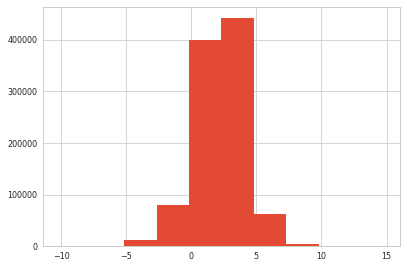

In [9]:
plt.hist(T)
plt.show()

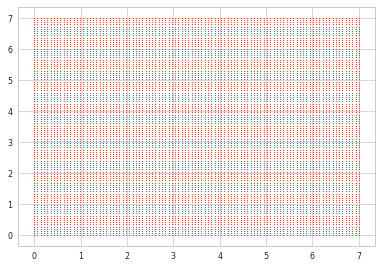

In [10]:
plt.plot(x,y,'.',markersize=1)
plt.show()

In [11]:
len(T)

1000000

In [ ]:
plt = matplotlib.pyplot
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Polygon
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=14, family='monospace')

plt.scatter(x,y,c=T,cmap='viridis',s=200)#,s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlim(0.000001, 6.99999)
plt.ylim(0.000001, 6.99999)

cbar.ax.tick_params(labelsize=10)
cbar.set_label('Observed data',size=15)

tick_locator = tick.MaxNLocator(nbins=10)
cbar.locator = tick_locator
cbar.update_ticks()

plt.tight_layout()

plt.savefig("Sythetic_dataset_2D.png",dpi=300)

plt.show()


In [ ]:
plt.scatter(x,y,c=true_len,cmap='viridis',s=200)#,s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('True lengthscale',size=15)
plt.show()


In [ ]:
#ns mean spatial data

#f, (ax1, ax2,ax3,ax4) = plt.subplots(1,4,figsize=(40,10))

plt = matplotlib.pyplot
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Polygon
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=14, family='monospace')

fig, axs = plt.subplots(1, 4,figsize=(40,10))

ax0 = axs[0].scatter(x,y,c=T,cmap='viridis',s=200)
axs[0].set_xlabel('Longitude',size=35)
axs[0].set_ylabel('Latitude',size=35)
axs[0].text(-0.05,1,'A', size=35, transform=axs[0].transAxes)
axs[0].tick_params(axis='both', which='major', labelsize=35)

cbar = fig.colorbar(ax0, ax=axs[0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Data',size=35)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

ax1 = axs[1].scatter(x,y,c=true_mean,cmap='viridis',s=200)
axs[1].set_xlabel('Longitude',size=35)
axs[1].set_ylabel('Latitude',size=35)
axs[1].text(-0.05,1,'B', size=35, transform=axs[1].transAxes)
axs[1].tick_params(axis='both', which='major', labelsize=35)

cbar = fig.colorbar(ax1, ax=axs[1],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('True Mean',size=35)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

ax2 = axs[2].scatter(x,y,c=true_len,cmap='viridis',s=200)
axs[2].set_xlabel('Longitude',size=35)
axs[2].set_ylabel('Latitude',size=35)
axs[2].text(-0.05,1,'C', size=35, transform=axs[2].transAxes)
axs[2].tick_params(axis='both', which='major', labelsize=35)

cbar = fig.colorbar(ax2, ax=axs[2],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('True lengthscale',size=35)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

ax3 = axs[3].scatter(x,y,c=true_amp,cmap='viridis',s=200)
axs[3].set_xlabel('Longitude',size=35)
axs[3].set_ylabel('Latitude',size=35)
axs[3].text(-0.05,1,'D', size=35, transform=axs[3].transAxes)
axs[3].tick_params(axis='both', which='major', labelsize=35)

cbar = fig.colorbar(ax3, ax=axs[3],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('True amplitiude',size=35)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

fig.tight_layout()

plt.savefig("Sythetic_dataset_2D.pdf",dpi=300)

In [12]:
X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y 


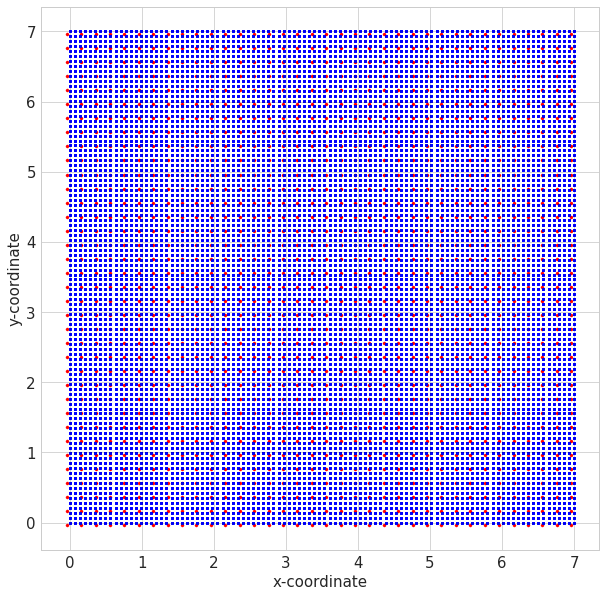

In [13]:
#More inducing points
# Set up the grid 
offsety = 0.1
offsetx = 0.1

gridwidth = 0.2

xmin = gridwidth*(((x.min()-offsetx)//gridwidth)+0.3)
xmax = gridwidth*(((x.max()+offsetx)//gridwidth)+1.30)

ymin = gridwidth*(((y.min()-offsety)//gridwidth)+0.3)
ymax = gridwidth*(((y.max()+offsety)//gridwidth)+1.30)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

plt.figure(figsize=(10,10))
ax = plt.subplot()

plt.plot(x,y,'.',c='b',alpha=0.05)
plt.scatter(x_grid[:,0],x_grid[:,1],s=10,c='r')
plt.xlabel('x-coordinate',size=15)
plt.ylabel('y-coordinate',size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

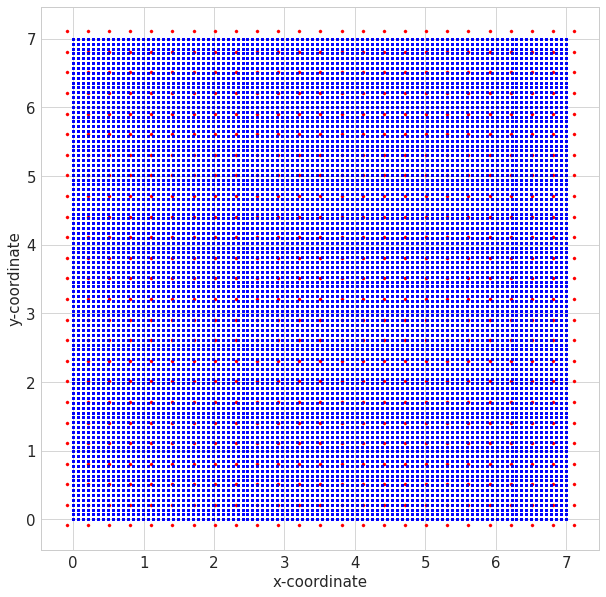

In [25]:
#less inducing points
# Set up the grid 
offsety = 0.1
offsetx = 0.1

gridwidth = 0.3

xmin = gridwidth*(((x.min()-offsetx)//gridwidth)+0.2)
xmax = gridwidth*(((x.max()+offsetx)//gridwidth)+1.35)

ymin = gridwidth*(((y.min()-offsety)//gridwidth)+0.2)
ymax = gridwidth*(((y.max()+offsety)//gridwidth)+1.35)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

plt.figure(figsize=(10,10))
ax = plt.subplot()

plt.plot(x,y,'.',c='b',alpha=0.05)
plt.scatter(x_grid[:,0],x_grid[:,1],s=10,c='r')
plt.xlabel('x-coordinate',size=15)
plt.ylabel('y-coordinate',size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [26]:
num_inducing_points_ = x_grid.shape[0]
np.random.shuffle(x_grid)

print(num_inducing_points_)
print(x_grid.shape)

inducing_index_points  = x_grid

625
(625, 2)


In [27]:
#inducing_index_points,x,y,x_grid,X

In [28]:
num_training_points_ = T.shape[0]
print(num_training_points_)

1000000


In [29]:
BATCH_SIZE=4
SEG_LENGTH=500 


class segment_generator:
    def __iter__(self):
        
        # loop over segments
        self.j = 0
        self.max_j = num_training_points_//SEG_LENGTH
         
        return self

    def __next__(self):
        

        if self.j==self.max_j:
            raise StopIteration

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.j += 1

        return XX,TT # XX is the input now-2D, TT -temp is the output-1d

        
#dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64)) 

dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,2]),tf.TensorShape([None,1]))) 
dataset = dataset.shuffle(500)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [30]:
#for d in dataset:
    #print(d[0].shape,d[1].shape)

In [31]:
#lengthscale kernel parameters,lower levels
kernel_len_a = tfp.util.TransformedVariable(1.5, tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(4.0, tfb.Chain([tfb.Shift(np.float64(0.0)), tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(1.5, tfb.Softplus(),dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(4.0, tfb.Chain([tfb.Shift(np.float64(0.0)), tfb.Softplus()]),dtype=tf.float64, name='k_amp_l',trainable=True)

# mean kernel parameters, lower levels
kernel_mean_a = tfp.util.TransformedVariable(1.5, tfb.Softplus(),dtype=tf.float64, name='k_mean_a',trainable=True)
kernel_mean_l = tfp.util.TransformedVariable(4.0, tfb.Chain([tfb.Shift(np.float64(0.0)), tfb.Softplus()]),dtype=tf.float64, name='k_mean_l',trainable=True)

#kernels on the second layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)
kernel_mean = tfk.ExponentiatedQuadratic(kernel_mean_a,kernel_mean_l)

#added kernel_mean
vgp = nsgp_vi_3ns_params_2D(kernel_len,kernel_amp,kernel_mean,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=5,num_parallel_samples=30,init_observation_noise_variance=1e1) 
# more parallel samples, noise 10

In [32]:
tf.math.softplus(0.0476085)

<tf.Tensor: shape=(), dtype=float32, numpy=0.71723473>

In [33]:
vgp.trainable_variables

(<tf.Variable 'k_amp_a:0' shape=() dtype=float64, numpy=1.247517541074546>,
 <tf.Variable 'k_amp_l:0' shape=() dtype=float64, numpy=3.9815145531741134>,
 <tf.Variable 'k_len_a:0' shape=() dtype=float64, numpy=1.247517541074546>,
 <tf.Variable 'k_len_l:0' shape=() dtype=float64, numpy=3.9815145531741134>,
 <tf.Variable 'k_mean_a:0' shape=() dtype=float64, numpy=1.247517541074546>,
 <tf.Variable 'k_mean_l:0' shape=() dtype=float64, numpy=3.9815145531741134>,
 <tf.Variable 'var_mean:0' shape=(1,) dtype=float64, numpy=array([0.])>,
 <tf.Variable 'len_mean:0' shape=(1,) dtype=float64, numpy=array([0.])>,
 <tf.Variable 'mean_mean:0' shape=(1,) dtype=float64, numpy=array([0.])>,
 <tf.Variable 'ind_loc_post:0' shape=(1875,) dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>,
 <tf.Variable 'ind_scale_post:0' shape=(1758750,) dtype=float64, numpy=
 array([0.54130903, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ])>,
 <tf.Variable 'nv:0' shape=() dtype=float64, n

In [ ]:
#loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=2000)
#maybe try a lower learning rate

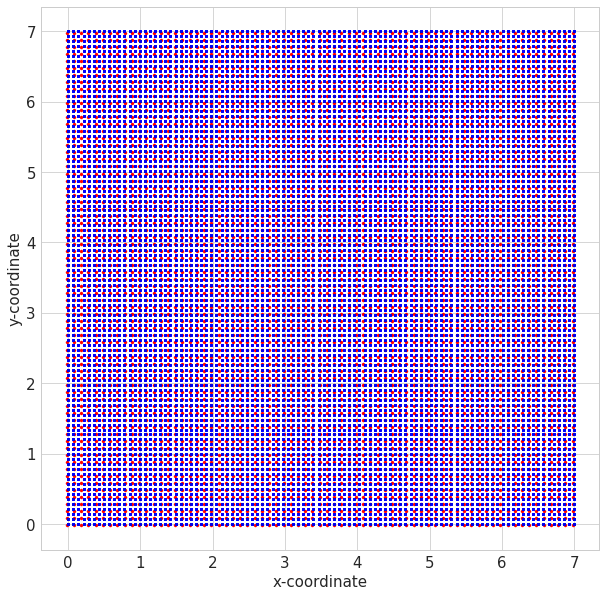

In [37]:
# define the prediction grid
# Set up the grid 
offsety = 0.1
offsetx = 0.1

gridwidth = 0.1

xmin = gridwidth*(((x.min()-offsetx)//gridwidth)+0.3)
xmax = gridwidth*(((x.max()+offsetx)//gridwidth)+1.30)

ymin = gridwidth*(((y.min()-offsety)//gridwidth)+0.3)
ymax = gridwidth*(((y.max()+offsety)//gridwidth)+1.30)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

px_grid = np.array([xx.flatten(), yy.flatten()])
px_grid = px_grid.T

plt.figure(figsize=(10,10))
ax = plt.subplot()

plt.plot(x,y,'.',c='b',alpha=0.05)
plt.scatter(px_grid[:,0],px_grid[:,1],s=10,c='r')
plt.xlabel('x-coordinate',size=15)
plt.ylabel('y-coordinate',size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [38]:
ZZ=px_grid#=x_grid

# predictions

[mean_mean,len_mean,amp_mean], [mean_var,len_var,amp_var] = vgp.get_marginal(ZZ[None,...])

mean_mean = mean_mean[0,:,0].numpy()
mean_std = mean_var[:,0].numpy()**0.5


len_mean = len_mean[0,:,0].numpy()
len_std = len_var[:,0].numpy()**0.5

amp_mean = amp_mean[0,:,0].numpy()
amp_std = amp_var[:,0].numpy()**0.5



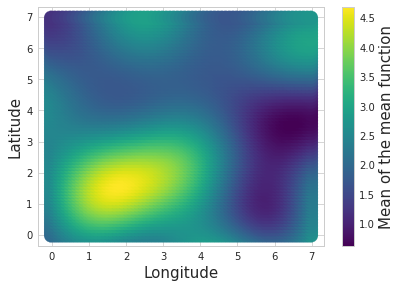

In [25]:
plt.scatter(px_grid[:,0],px_grid[:,1],c=vgp.mean_mean + mean_mean,cmap='viridis',marker='o',s=200)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Mean of the mean function',size=15)
plt.show()


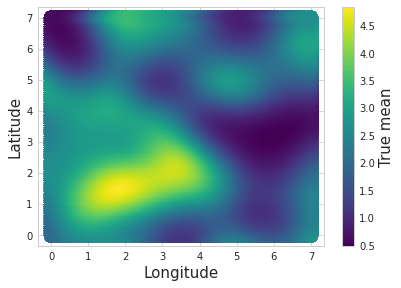

In [26]:
plt.scatter(x,y,c=true_mean,cmap='viridis',s=200)#,s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('True mean',size=15)
plt.show()


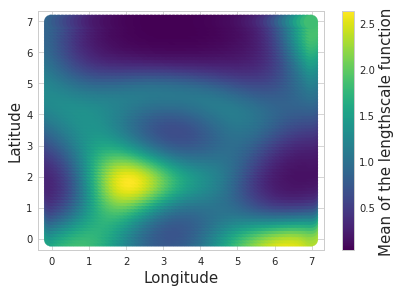

In [27]:
plt.scatter(px_grid[:,0],px_grid[:,1],c=tf.math.softplus(vgp.mean_len + len_mean),cmap='viridis',marker='o',s=200)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Mean of the lengthscale function',size=15)
plt.show()


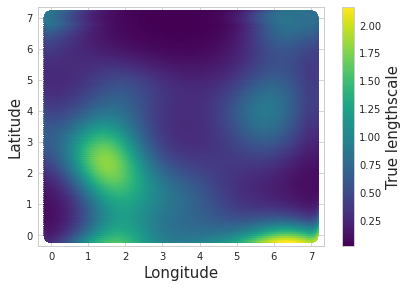

In [28]:
plt.scatter(x,y,c=true_len,cmap='viridis',s=200)#,s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('True lengthscale',size=15)
plt.show()


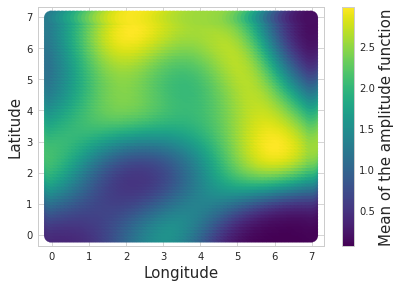

In [29]:
plt.scatter(px_grid[:,0],px_grid[:,1],c=tf.math.softplus(vgp.mean_amp + amp_mean),cmap='viridis',marker='o',s=200)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Mean of the amplitude function',size=15)
plt.show()


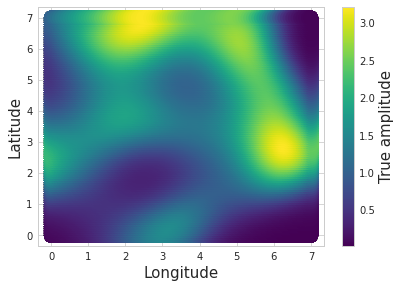

In [30]:
plt.scatter(x,y,c=true_amp,cmap='viridis',s=200)#,s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
cbar= plt.colorbar()
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('True amplitude',size=15)
plt.show()


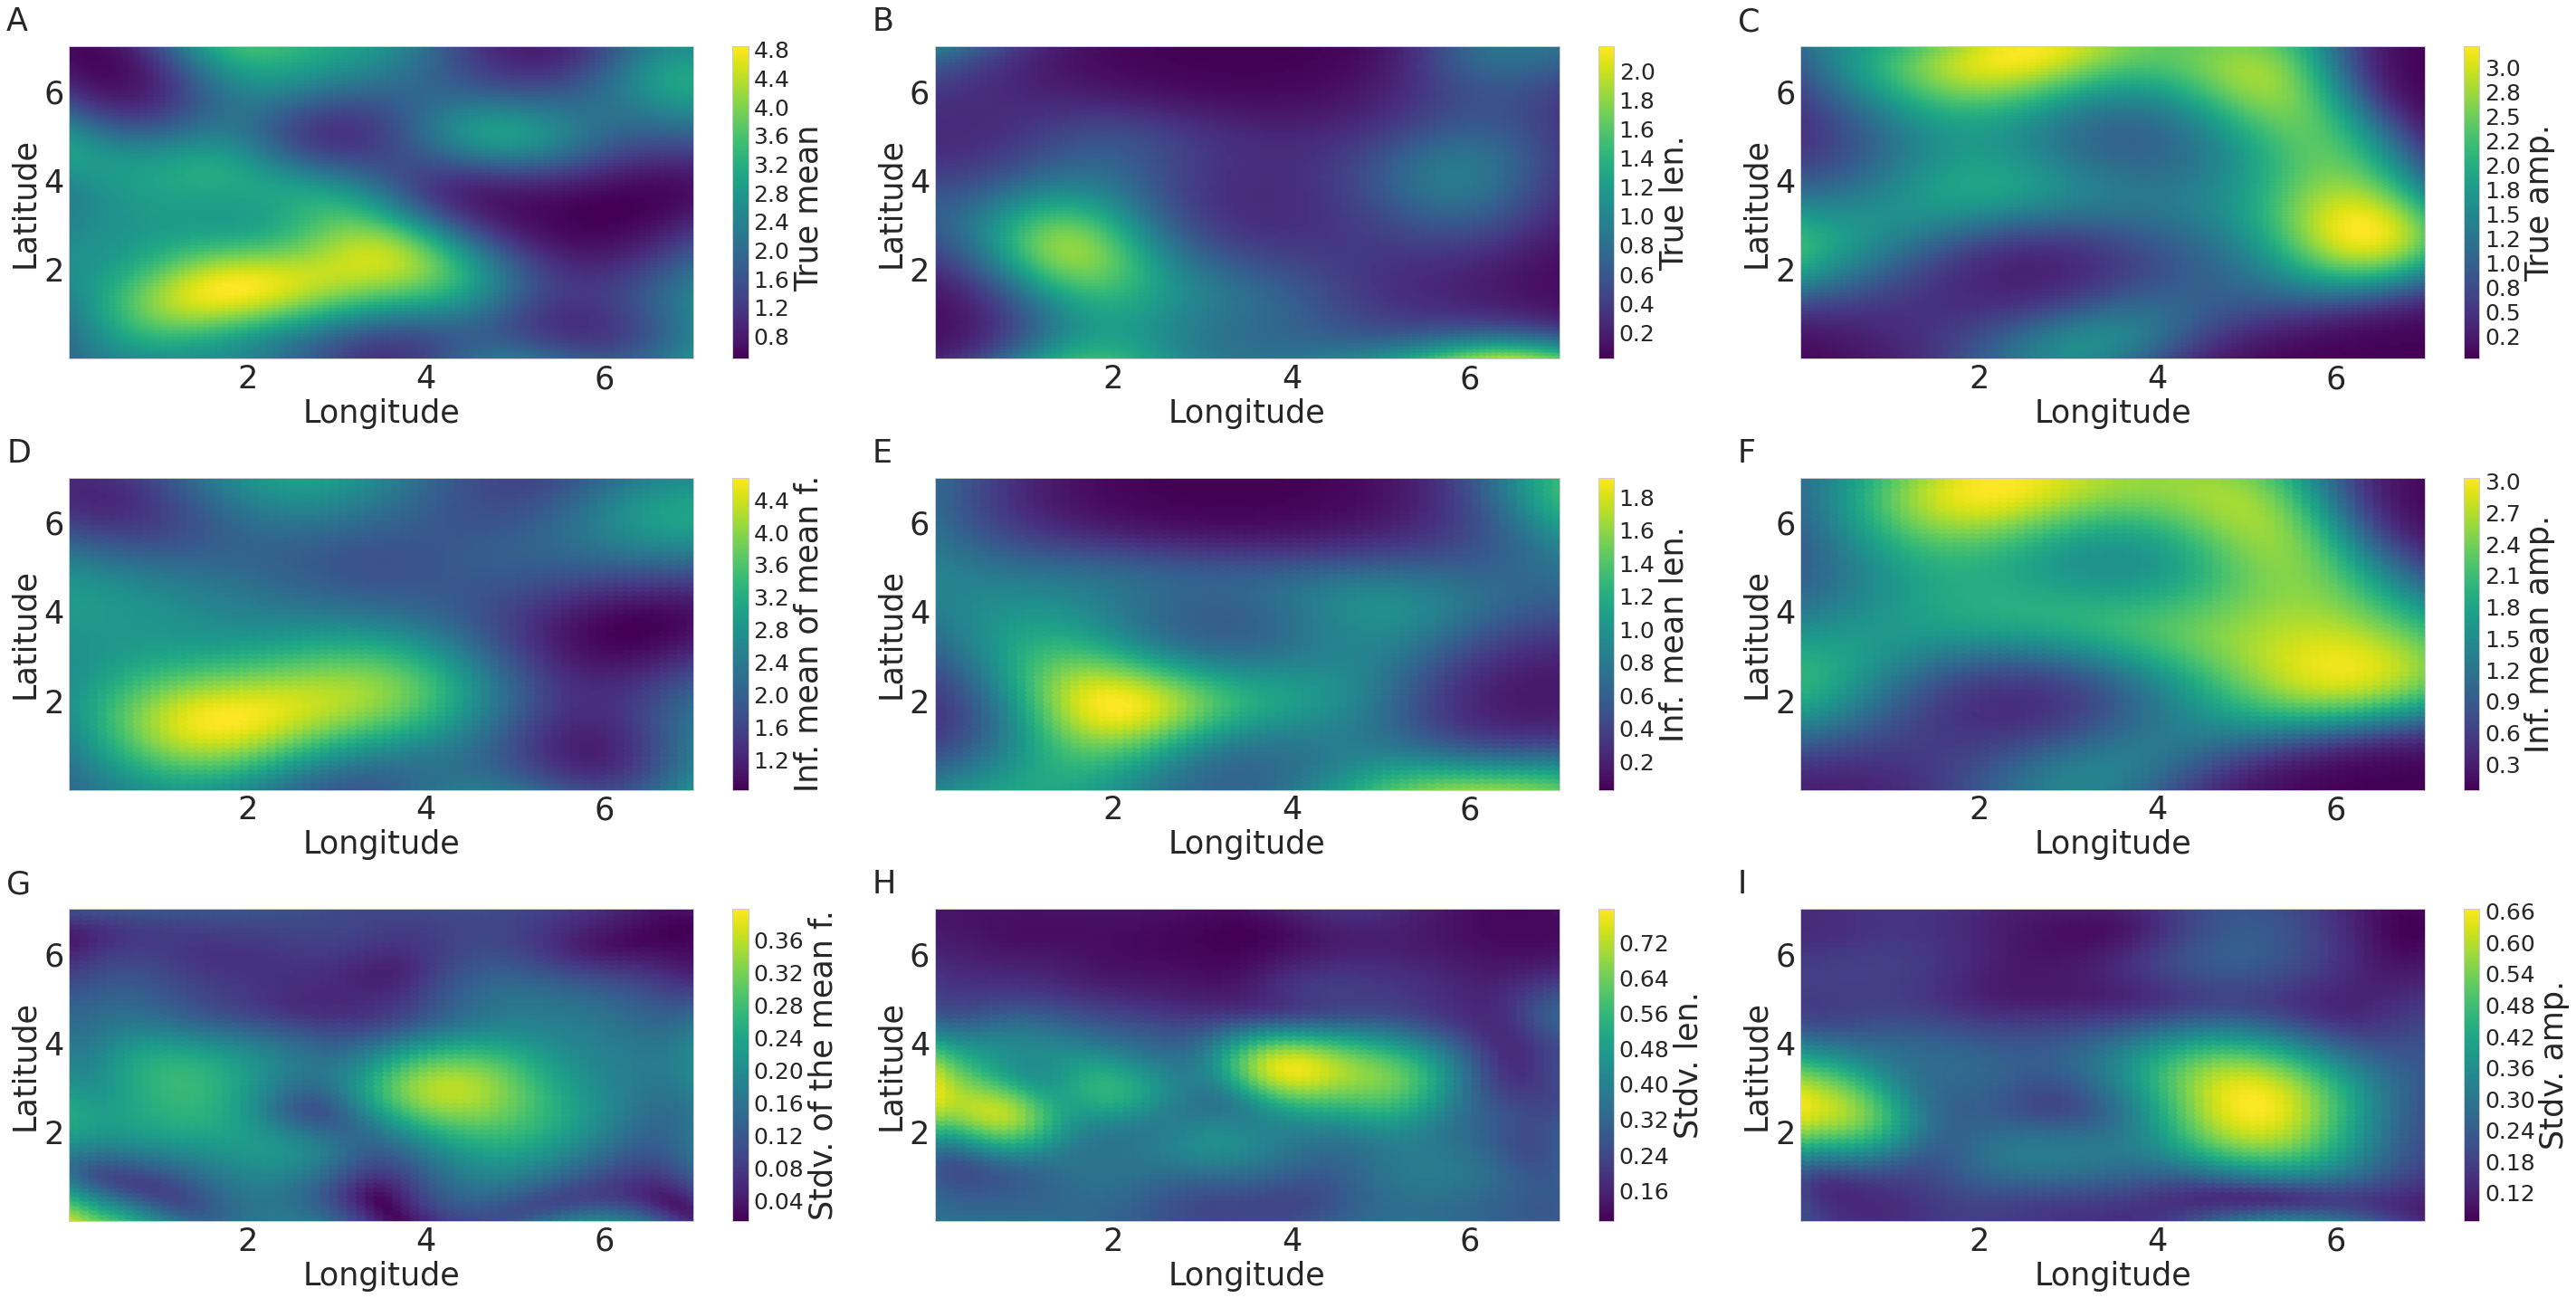

In [39]:
plt = matplotlib.pyplot
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Polygon
import matplotlib.font_manager as fm
#fontprops = fm.FontProperties(size=14, family='monospace')


fig, axs = plt.subplots(3, 3,figsize=(40,20))

# true values

# true mean 
ax00 = axs[0, 0].scatter(x,y,c=true_mean,cmap='viridis',s=200)
axs[0, 0].set_xlabel('Longitude',size=35)
axs[0, 0].set_ylabel('Latitude',size=35)

axs[0, 0].set_xlim(0.000001, 6.99999)
axs[0, 0].set_ylim(0.000001, 6.99999)

axs[0, 0].text(-0.1,1.05,'A', size=35, transform=axs[0, 0].transAxes)
axs[0, 0].tick_params(axis='both', which='major', labelsize=35)

cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('True mean ',size=35)
tick_locator = tick.MaxNLocator(nbins=14)
cbar.locator = tick_locator
cbar.update_ticks()

# true len
ax01 = axs[0, 1].scatter(x,y,c = true_len,cmap='viridis',s=200)
axs[0, 1].set_xlabel('Longitude',size=35)
axs[0, 1].set_ylabel('Latitude',size=35)
axs[0, 1].text(-0.1,1.05,'B', size=35, transform=axs[0, 1].transAxes)
axs[0, 1].tick_params(axis='both', which='major', labelsize=35)

axs[0, 1].set_xlim(0.000001, 6.99999)
axs[0, 1].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax01, ax=axs[0, 1],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('True len.',size=35)
tick_locator = tick.MaxNLocator(nbins=14)
cbar.locator = tick_locator
cbar.update_ticks()

# true amp
ax02=axs[0, 2].scatter(x,y,c=true_amp,cmap='viridis',s=200)
axs[0, 2].set_xlabel('Longitude',size=35)
axs[0, 2].set_ylabel('Latitude',size=35)
axs[0, 2].text(-0.1,1.05,'C', size=35, transform=axs[0, 2].transAxes)
axs[0, 2].tick_params(axis='both', which='major', labelsize=35)

axs[0, 2].set_xlim(0.000001, 6.99999)
axs[0, 2].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax02, ax=axs[0, 2],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('True amp.',size=35)
tick_locator = tick.MaxNLocator(nbins=14)
cbar.locator = tick_locator
cbar.update_ticks()


#inferred values
#mean_mean
ax10 = axs[1, 0].scatter(px_grid[:,0],px_grid[:,1],c=vgp.mean_mean + mean_mean,cmap='viridis',s=200)
axs[1, 0].set_xlabel('Longitude',size=35)
axs[1, 0].set_ylabel('Latitude',size=35)
axs[1, 0].text(-0.1,1.05,'D', size=35, transform=axs[1, 0].transAxes)
axs[1, 0].tick_params(axis='both', which='major', labelsize=35)

axs[1, 0].set_xlim(0.000001, 6.99999)
axs[1, 0].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax10, ax=axs[1, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Inf. mean of mean f.',size=35)
tick_locator = tick.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

#mean_len
ax11 = axs[1, 1].scatter(px_grid[:,0],px_grid[:,1],c = tf.math.softplus(vgp.mean_len + len_mean),cmap='viridis',s=200)
axs[1, 1].set_xlabel('Longitude',size=35)
axs[1, 1].set_ylabel('Latitude',size=35)
axs[1, 1].text(-0.1,1.05,'E', size=35, transform=axs[1, 1].transAxes)
axs[1, 1].tick_params(axis='both', which='major', labelsize=35)

axs[1, 1].set_xlim(0.000001, 6.99999)
axs[1, 1].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax11, ax=axs[1, 1],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Inf. mean len.',size=35)
tick_locator = tick.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

#mean_amp
ax12=axs[1, 2].scatter(px_grid[:,0],px_grid[:,1],c=tf.math.softplus(vgp.mean_amp + amp_mean),cmap='viridis',s=200)
axs[1, 2].set_xlabel('Longitude',size=35)
axs[1, 2].set_ylabel('Latitude',size=35)
axs[1, 2].text(-0.1,1.05,'F', size=35, transform=axs[1, 2].transAxes)
axs[1, 2].tick_params(axis='both', which='major', labelsize=35)

axs[1, 2].set_xlim(0.000001, 6.99999)
axs[1, 2].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax12, ax=axs[1, 2],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Inf. mean amp.',size=35)
tick_locator = tick.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

#mean_stdv
ax20=axs[2, 0].scatter(px_grid[:,0],px_grid[:,1],c=mean_std,cmap='viridis',s=200)
axs[2, 0].set_xlabel('Longitude',size=35)
axs[2, 0].set_ylabel('Latitude',size=35)
axs[2, 0].text(-0.1,1.05,'G', size=35, transform=axs[2, 0].transAxes)
axs[2, 0].tick_params(axis='both', which='major', labelsize=35)

axs[2, 0].set_xlim(0.000001, 6.99999)
axs[2, 0].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax20, ax=axs[2, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Stdv. of the mean f.',size=35)
tick_locator = tick.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

#len_stdv
ax21=axs[2, 1].scatter(px_grid[:,0],px_grid[:,1],c=len_std,cmap='viridis',s=200)
axs[2, 1].set_xlabel('Longitude',size=35)
axs[2, 1].set_ylabel('Latitude',size=35)
axs[2, 1].text(-0.1,1.05,'H', size=35, transform=axs[2,1].transAxes)
axs[2, 1].tick_params(axis='both', which='major', labelsize=35)

axs[2, 1].set_xlim(0.000001, 6.99999)
axs[2, 1].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax21, ax=axs[2, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Stdv. len.',size=35)
tick_locator = tick.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()


#amp_stdv
ax22=axs[2, 2].scatter(px_grid[:,0],px_grid[:,1],c=amp_std,cmap='viridis',s=200)
axs[2, 2].set_xlabel('Longitude',size=35)
axs[2, 2].set_ylabel('Latitude',size=35)
axs[2, 2].text(-0.1,1.05,'I', size=35, transform=axs[2, 2].transAxes)
axs[2, 2].tick_params(axis='both', which='major', labelsize=35)
tick_locator = tick.MaxNLocator(nbins=11)

axs[2, 2].set_xlim(0.000001, 6.99999)
axs[2, 2].set_ylim(0.000001, 6.99999)

cbar = fig.colorbar(ax22, ax=axs[2, 2],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Stdv. amp.',size=35)
tick_locator = tick.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()


fig.tight_layout()

plt.savefig("vi_2d_spatial_data.png",bbox_inches='tight',dpi=300)
plt.show()



In [ ]:
#!pip install pickle5

In [34]:
import pickle5 as pickle

#Load the inducing points and the optimized parameters 
with open('/kaggle/input/ch6-2d-data-results/3tryperfect_less-ind-points-100indv-upd-syn-inf-2d-all-ns-param.pkl', 'rb') as f:
    loadp = pickle.load(f)
    
inducing_index_points = np.load('/kaggle/input/ch6-2d-data-results/3tryperfect-less-ind-points-100indv-upd-syn-inf-2d-all-ns-index-points.npy')    

In [35]:
vgp = nsgp_vi_3ns_params_2D(kernel_len,kernel_amp,kernel_mean,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=20,num_parallel_samples=10,init_observation_noise_variance=0.005**2) 


In [36]:
#Load the parameters !!!
for np_v, tf_v in zip(loadp,vgp.trainable_variables):
    tf_v.assign(np_v)